In [4]:
import os
from dotenv import load_dotenv
load_dotenv()


GROQ_API_KEY=os.getenv("GROQ_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY


In [1]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [6]:
llm.invoke("hi").content

'Hi! 👋\n\nHow can I help you today? 😄\n'

In [7]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [8]:
multiply({"first_number":24,"second_number":364})

C:\Users\JAGADEESHNAIKPALTHYA\AppData\Local\Temp\ipykernel_3476\2089873997.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [9]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [10]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [11]:
search("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Current president\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\nFormer U.S. presidents\nThe United States has had 46 former U.S. presidents. Read about past presidents and vice presidents.\nMany former presidents have presidential libraries and museums you can visit to learn about their lives and their time in office. Find presidential libraries and museums.\nRequirements to be eligible to become president [...] Current first lady\nThe current first lady of the United States is Melania Trump.\nFormer first ladies\nFind a list of former first ladies and their presidential spouses.\nSee the Smithsonian Institution's virtual tour of first ladies' inaugural ball gowns and other artifacts.\nHow to contact the president, vice president, and first lady\nThe president, vice president, and fir

In [12]:
search.invoke("who is a current president of USA?")

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Current president\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\nFormer U.S. presidents\nThe United States has had 46 former U.S. presidents. Read about past presidents and vice presidents.\nMany former presidents have presidential libraries and museums you can visit to learn about their lives and their time in office. Find presidential libraries and museums.\nRequirements to be eligible to become president [...] Current first lady\nThe current first lady of the United States is Melania Trump.\nFormer first ladies\nFind a list of former first ladies and their presidential spouses.\nSee the Smithsonian Institution's virtual tour of first ladies' inaugural ball gowns and other artifacts.\nHow to contact the president, vice president, and first lady\nThe president, vice president, and fir

In [13]:
tools=[search,multiply]

In [14]:
model_with_tools = llm.bind_tools(tools)

In [17]:
tool_mapping={tool.name: tool for tool in tools}

In [18]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000023A45E70A40>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000023A45E70400>)}

In [19]:
response = model_with_tools.invoke("who is a current president of USA?")

In [20]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ewvy', 'function': {'arguments': '{"query":"who is the current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.155946691, 'queue_time': 0.24908496700000002, 'total_time': 0.312310327}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2f7b11a0-4677-4aa9-aeae-38d42b7b379f-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of USA'}, 'id': 'call_ewvy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162})

In [21]:
tool_details=response.additional_kwargs.get("tool_calls")

In [22]:
tool_details

[{'id': 'call_ewvy',
  'function': {'arguments': '{"query":"who is the current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [23]:
tool_details[0]["function"]["name"]

'search'

In [24]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of USA"}'

In [25]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is the current president of USA'}

In [26]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': "Current president\nThe 47th and current president of the United States is Donald John Trump.\xa0He was sworn into office on January 20, 2025.\nFormer U.S. presidents\nThe United States has had 46 former U.S. presidents. Read about past presidents and vice presidents.\nMany former presidents have presidential libraries and museums you can visit to learn about their lives and their time in office. Find presidential libraries and museums.\nRequirements to be eligible to become president [...] Current first lady\nThe current first lady of the United States is Melania Trump.\nFormer first ladies\nFind a list of former first ladies and their presidential spouses.\nSee the Smithsonian Institution's virtual tour of first ladies' inaugural ball gowns and other artifacts.\nHow to contact the president, vice president, and first lady\nThe president, vice president, and fir

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [28]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [29]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [30]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [31]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [32]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [33]:
app = graph.compile()

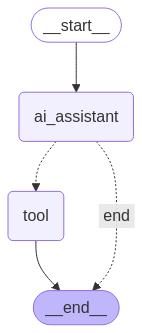

In [34]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))